# Clasificador de flores Manual
En esta lección vamos a programar nuestro model desde 0. No usaremos transfer learning, así que no obtendremos un resultado tan bueno (o siquiera "bueno"). Haremos una red pequeña.

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import fastai
import fastai.basics as fai
import fastai.vision as fv

import torch
import torch.nn as nn
import torch.nn.functional as F

import gc
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np

import torchvision
import torchvision.utils as utils

In [3]:
flowers = Path("flowers")

In [ ]:
def load_data(folder, img_size, batch_size):
    tfms = fv.get_transforms(flip_vert=True, max_rotate=360) #tfms = transforms
    data = (fv.ImageList
            .from_folder(folder)
            .split_by_folder()
            .label_from_folder()
            .transform(tfms,size=img_size)
            .databunch(bs=batch_size))
    return data

In [ ]:
data = load_data(flowers, img_size=224, batch_size=128)

In [ ]:
data.show_batch(rows=2)

## Algunas funciones de ayuda

Para nuestro primer modelo vamos a crear algunas capas y funciones de ayuda. Honestamente, no se por qué no las trae pytorch, si son bien útiles.

In [4]:
# Esta capa servirá para conectar las convolucionales con las lineales (densas)
class Flatten(nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, x):
        return x.squeeze()

# para tener idea de qué tan grande es nuestro modelo
def num_params(model):
    total=0
    for p in model.parameters():
        num=1
        for s in list(p.size()):
            num *= s
        total += num
    return total

In [ ]:
img=torch.rand((5,3,128,128))

In [ ]:
content_img = fv.open_image("flowers/valid/camellia/image_07600.jpg");
content_img

In [ ]:
capa = nn.Conv2d(3,3,kernel_size=(3,3))

In [ ]:
num_params(capa)

In [ ]:
A=content_img.data

In [ ]:
A.shape

In [ ]:
A.unsqueeze_(0)

In [ ]:
A.shape

In [5]:
def show_tensor_as_image(tensor, ncols=5, figsize=10, title = ""):
    plt.figure(figsize=(figsize,figsize))
    plt.axis("off")
    plt.title(title)
    plt.imshow(np.transpose(utils.make_grid(tensor.detach().cpu()[:ncols*ncols], nrow=ncols, padding=2, normalize=True).cpu(),(1,2,0)))

In [ ]:
show_tensor_as_image(img)

In [ ]:
show_tensor_as_image(capa(img))

In [ ]:
show_tensor_as_image(capa(A))

In [ ]:
# Primer intento: completamente manual!
model = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(128, 192, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(192, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1),
            nn.Tanh(), 
            fv.AdaptiveConcatPool2d(),
            Flatten(),
            nn.Linear(384*2, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, data.c))
model

In [ ]:
num_params(model)

In [ ]:
learner = fai.Learner(data, model, metrics=fai.accuracy)

In [ ]:
learner.summary()

In [ ]:
learner.lr_find(); learner.recorder.plot()

In [ ]:
learner.fit_one_cycle(5,1e-3)

# Mejorando el model inicial
Ya se ve que no vamos a llegar fácilmente a accuracy alta. Esto es por varias razones. Nos falta:

- Transfer learning
- BatchNorm
- Resnet
- Más capas

Estas últimas tres vamos a mejorarlas ahora.


## Batch norm

Primero batchnorm. Podríamos simplemente tomar el modelo que hicimos hace rato y agregar batchnorms, pero se empieza a volver *feyecito*.

**Nota**: A mi me gusta poner la activación (y BatchNorm) ANTES de las capas convolucionales. En realidad no importa para nada: finalmente van intercalados. Excepto que se me hace más fácil de programar. Les explicaré por qué en un momento.

In [6]:
def conv_block(ni, no, k=3, s=1, pad="same", bn = True, activation = True, g = 1):
    if pad == "same": 
        pad = k//2
    
    layers = []
    
    if bn:
        layers += [nn.BatchNorm2d(ni)]
       
    if activation:
        layers += [nn.ReLU(inplace=True)]
    
    layers += [nn.Conv2d(ni, no, kernel_size=k, stride=s, padding=pad, bias = not bn, groups=g)]
    
    return nn.Sequential(*layers)

`activation=False` al principio es para empezar directamente con batchnorm y no con activación. Los que ponen su activación después de la capa convolucional tendrían que poner activation=False al final

In [7]:
model = nn.Sequential(
            conv_block(3, 64, k=7, s=2, activation=False),
            nn.MaxPool2d(2),
            conv_block(64, 128),
            nn.MaxPool2d(2),
            conv_block(128, 192),
            nn.MaxPool2d(2),
            conv_block(192, 256),
            nn.MaxPool2d(2),
            conv_block(256, 384),
            nn.Tanh(), 
            fai.AdaptiveConcatPool2d(),
            Flatten(),
            nn.Linear(2*384, 256),
            nn.LeakyReLU(inplace=True),
            nn.Linear(256, 102)
        )
num_params(model)

1855788

In [ ]:
learner = fai.Learner(data, model, metrics=fai.accuracy, wd=0.05)

In [ ]:
gc.collect() # pa no acabarnos la memoria. gc = garbage collector

In [ ]:
learner.summary()

In [ ]:
learner.lr_find(); learner.recorder.plot()

In [ ]:
learner.fit_one_cycle(5,2e-3)

No está tan mal, considerando que tenemos 1/6 parte de los parámetros de resnet18:

In [ ]:
print(num_params(fv.models.resnet18()))
num_params(fv.models.resnet18())/num_params(model)

## Resnets

¿Podemos hacerlo mejor? Sí, con los llamados "resblocks" (skip connections). Eso significa que guardas el resultado de una capa y la sumas un par de capas después. Esto permite entrenar redes mucho más profundas!

In [ ]:
class ResBlock(nn.Module):
    def __init__(self, nf):
        super().__init__()
        
        self.residual = nn.Sequential(conv_block(nf,nf//4,k=1), 
                                      conv_block(nf//4,nf//4,g=2), 
                                      conv_block(nf//4,nf,k=1))
        
    def forward(self, x):
        return x + self.residual(x)

In [ ]:
L = [1,2,3,4,5,6,7]

In [ ]:
for a,b in zip(L,L[1:]):
    print(a,b)

In [ ]:
def resnet_body(filters):
    layers = [conv_block(3, filters[0], k=7, s=2, activation=False)]
    
    for ni, no in zip(filters[:-1], filters[1:]):
        layers += [nn.MaxPool2d(2), ResBlock(ni), conv_block(ni,no)]
        
    return layers

In [ ]:
layers = resnet_body([64,96,128,192,256])
layers +=[nn.Tanh(),
          fai.AdaptiveConcatPool2d(),
          Flatten(),
          nn.Dropout(0.5),
          nn.Linear(512, 256),
          nn.Dropout(0.2),
          nn.LeakyReLU(inplace=True),
          nn.Linear(256, 102)]
model = nn.Sequential(*layers)

In [ ]:
num_params(model)

In [ ]:
learner = fai.Learner(data, model, wd=0.1, metrics=fai.accuracy)

In [ ]:
gc.collect()

In [ ]:
learner.summary()

In [ ]:
learner.lr_find(); learner.recorder.plot()

In [ ]:
learner.fit_one_cycle(5,2e-3)

# Más manual: datasets, dataloaders

In [8]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import PIL

In [9]:
class ImgTransforms():
    def __init__(self, img_size):
        self.img_size = img_size

    def __call__(self, img, a=0.03):
        t = [transforms.RandomResizedCrop(self.img_size,scale=(0.9, 1.0), ratio=(0.9, 1.1)),
             transforms.ColorJitter(brightness=a, contrast=a, saturation=a, hue=a/10), 
             transforms.RandomHorizontalFlip(p=0.5),
             transforms.ToTensor()]
        tfms = transforms.Compose(t)
        
        return tfms(img)

In [10]:
tfms = ImgTransforms(256)

In [11]:
img = PIL.Image.open("flowers/valid/artichoke/image_04090.jpg")

In [12]:
tfms(img)

tensor([[[0.0588, 0.0549, 0.0549,  ..., 0.0902, 0.0941, 0.0941],
         [0.0588, 0.0549, 0.0549,  ..., 0.0667, 0.0784, 0.0863],
         [0.0824, 0.0824, 0.0824,  ..., 0.0706, 0.0784, 0.0863],
         ...,
         [0.0902, 0.0863, 0.0863,  ..., 0.0824, 0.0863, 0.0902],
         [0.0902, 0.0902, 0.0902,  ..., 0.0863, 0.0863, 0.0902],
         [0.0902, 0.0902, 0.0902,  ..., 0.0863, 0.0863, 0.0902]],

        [[0.0549, 0.0510, 0.0510,  ..., 0.0824, 0.0863, 0.0863],
         [0.0549, 0.0510, 0.0510,  ..., 0.0588, 0.0706, 0.0784],
         [0.0784, 0.0784, 0.0784,  ..., 0.0627, 0.0706, 0.0784],
         ...,
         [0.0745, 0.0745, 0.0706,  ..., 0.0784, 0.0824, 0.0863],
         [0.0863, 0.0863, 0.0824,  ..., 0.0784, 0.0784, 0.0824],
         [0.0863, 0.0863, 0.0824,  ..., 0.0784, 0.0784, 0.0824]],

        [[0.0627, 0.0588, 0.0588,  ..., 0.1216, 0.1255, 0.1255],
         [0.0627, 0.0588, 0.0588,  ..., 0.0980, 0.1098, 0.1176],
         [0.0863, 0.0863, 0.0863,  ..., 0.1020, 0.1098, 0.

In [13]:
class Img2Tensor():
    def __init__(self, img_size):
        self.img_size = img_size

    def __call__(self, img):
        t = [transforms.Resize((self.img_size,self.img_size)), 
             transforms.ToTensor()]
        tfms = transforms.Compose(t)
        
        return tfms(img)

In [14]:
class ImgDataset(Dataset):
    def __init__(self, filenames, labels, tfms):
        super().__init__()
        assert len(filenames) == len(labels)
        self.filenames = filenames
        self.labels = labels
        self.tfms = tfms
        
    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, i):
        img_name = self.filenames[i]
          
        image = self.tfms(PIL.Image.open(img_name))
    
        label = self.labels[i]
    
        return image, label

In [15]:
filenames=fv.get_image_files("flowers",recurse=True)

In [ ]:
len(filenames)

In [ ]:
filenames[:3]

In [17]:
import random

In [18]:
es_valid = [random.random()<0.12 for f in filenames]

In [19]:
files_valid = [f for v,f in zip(es_valid,filenames) if v]

In [20]:
files_train = [f for v,f in zip(es_valid,filenames) if not v]

In [21]:
len(files_valid)

992

In [22]:
len(files_train)

7196

In [23]:
f = filenames[0]

In [24]:
f

PosixPath('flowers/train/stemless-gentian/image_05227.jpg')

In [25]:
def extraer_cat_como_string(f):
    return f.parent.name

In [26]:
labels_str = [extraer_cat_como_string(f) for f in filenames]

In [27]:
filenames[-9:]

[PosixPath('flowers/valid/californian-poppy/image_03228.jpg'),
 PosixPath('flowers/valid/californian-poppy/image_03214.jpg'),
 PosixPath('flowers/valid/californian-poppy/image_03250.jpg'),
 PosixPath('flowers/valid/californian-poppy/image_03268.jpg'),
 PosixPath('flowers/valid/californian-poppy/image_03196.jpg'),
 PosixPath('flowers/valid/hard-leaved-pocket-orchid/image_05139.jpg'),
 PosixPath('flowers/valid/hard-leaved-pocket-orchid/image_05125.jpg'),
 PosixPath('flowers/valid/hard-leaved-pocket-orchid/image_05123.jpg'),
 PosixPath('flowers/valid/hard-leaved-pocket-orchid/image_05097.jpg')]

In [28]:
labels_str[-9:]

['californian-poppy',
 'californian-poppy',
 'californian-poppy',
 'californian-poppy',
 'californian-poppy',
 'hard-leaved-pocket-orchid',
 'hard-leaved-pocket-orchid',
 'hard-leaved-pocket-orchid',
 'hard-leaved-pocket-orchid']

In [29]:
categories = sorted(list(set(labels_str)))

In [30]:
categories[18]

'californian-poppy'

In [31]:
cat2idx = {nombre:i for i,nombre in enumerate(categories)}

In [32]:
labels = [cat2idx[l] for l in labels_str]

In [33]:
labels[-9:]

[18, 18, 18, 18, 18, 47, 47, 47, 47]

In [34]:
labels_train = [l for v,l in zip(es_valid,labels) if not v]
labels_valid = [l for v,l in zip(es_valid,labels) if v]

In [35]:
len(labels_valid)

992

In [36]:
train_ds = ImgDataset(files_train,labels_train,ImgTransforms(256))
valid_ds = ImgDataset(files_valid,labels_valid,Img2Tensor(256))

In [37]:
categories[valid_ds[184][1]]

'frangipani'

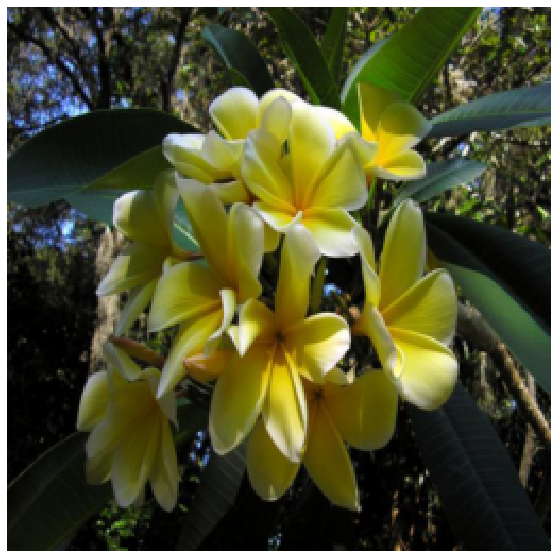

In [38]:
show_tensor_as_image(valid_ds[184][0])

In [39]:
categories[85]

'stemless-gentian'

In [40]:
len(train_ds)

7196

In [41]:
len(valid_ds)

992

In [42]:
train_dl = DataLoader(train_ds,batch_size=64,shuffle=True,num_workers=32)
valid_dl = DataLoader(valid_ds,batch_size=64,shuffle=True,num_workers=32)

In [43]:
len(train_dl)*64

7232

In [44]:
len(train_ds)

7196

In [45]:
model.cuda()

Sequential(
  (0): Sequential(
    (0): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  )
  (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (2): Sequential(
    (0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  )
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): ReLU(inplace=True)
    (2): Conv2d(128, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  )
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Sequential(
    (0): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, trac

In [46]:
from fastprogress.fastprogress import progress_bar

In [47]:
optimizer = torch.optim.SGD(model.parameters(),0.001,momentum=0.8)

In [56]:
def train_one_epoch(train_dl,model,optimizer):
    model.train()
    pbar =  progress_bar(train_dl)
    for imgs,labels in pbar:
        imgs,labels = imgs.cuda(), labels.cuda()
        optimizer.zero_grad()

        y = model(imgs)
        loss = F.cross_entropy(y,labels)

        loss.backward()
        optimizer.step()
        pbar.comment = f'{loss.item()}'

In [ ]:
y = torch.rand(64,102)

In [ ]:
labels = torch.randint(0,101, (64,))

In [52]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [53]:
def validate(valid_dl, model):
    total_loss = 0.
    total_acc = 0.
    model.eval()
    for imgs,labels in valid_dl:
        imgs,labels = imgs.cuda(), labels.cuda()
        y = model(imgs)
        loss = F.cross_entropy(y,labels)
        acc = torch.mean((torch.argmax(y,dim=1)==labels).float())
        total_acc += acc.item()
        total_loss += loss.item()
    n = len(valid_dl)
    return total_loss/n, total_acc/n

In [54]:
validate(valid_dl,model)

(4.62489053606987, 0.0087890625)

In [ ]:
for imgs,labels in valid_dl:
    print(imgs.shape)
    print(labels.shape)
    break

In [57]:
num_epochs = 10
for epoch in range(num_epochs):
    train_one_epoch(train_dl,model,optimizer)
    loss,acc = validate(valid_dl,model)
    print(f"{epoch}: loss = {loss}, accuracy = {acc}")

0: loss = 4.5483258664608, accuracy = 0.05078125


1: loss = 4.472568601369858, accuracy = 0.0458984375


2: loss = 4.400221884250641, accuracy = 0.044921875


3: loss = 4.317218720912933, accuracy = 0.0537109375


4: loss = 4.241526514291763, accuracy = 0.068359375


5: loss = 4.173334866762161, accuracy = 0.064453125


6: loss = 4.09154200553894, accuracy = 0.0810546875


7: loss = 4.006308034062386, accuracy = 0.0947265625


8: loss = 3.9399357587099075, accuracy = 0.0966796875


9: loss = 3.8636709451675415, accuracy = 0.095703125


Nota: ve como usar los databunch del fastai

In [58]:
data = fai.DataBunch.create(train_ds,valid_ds)

In [63]:
learn = fai.Learner(data,model,loss_func=F.cross_entropy,metrics=fai.accuracy)

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


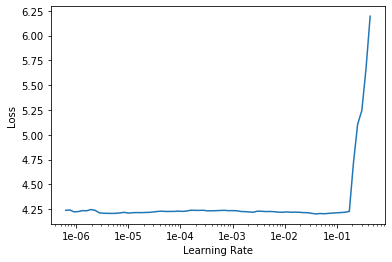

In [66]:
learn.lr_find(); learn.recorder.plot()

In [67]:
learn.fit_one_cycle(10,1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,4.198410,4.239560,0.057460,00:08
1,4.168818,4.163983,0.062500,00:08
2,4.044394,3.994138,0.089718,00:08
3,3.876282,3.845154,0.102823,00:08
4,3.736258,3.738443,0.110887,00:08
5,3.619678,3.601473,0.123992,00:08
6,3.490026,3.508695,0.131048,00:08
7,3.396806,3.430366,0.133065,00:08
8,3.319702,3.404723,0.140121,00:08
9,3.293393,3.402164,0.142137,00:08
